# Neural Networks

In this notebook we will learn to build and train an MLP in Pytorch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

## Ensure reproducibility

We need to set a random seed to ensure consistent results

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Get the data

Download the dataset - we will use `FahionMNIST`

In [5]:
ROOT = '.data'

train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting .data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting .data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]


Extracting .data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]

Extracting .data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



## Normalize the data

Recall that normalising data is important to avoid spurious biases. Here we divide the pixel vlaues by 255 to get a range of 0 - 1. We will use a `transform` to do this. A `transform` is an object that applies modifications to data as it is loaded and fed to the network for training.

We set up a `train_transform` and a `test_transform` for the different datasets. We then set up the data objects `train_data` and `test_data`.

In [6]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

## Take a look at the data

Its always a good idea to look a bit at the data. Here is a helper function to plot a set of the data.

In [7]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

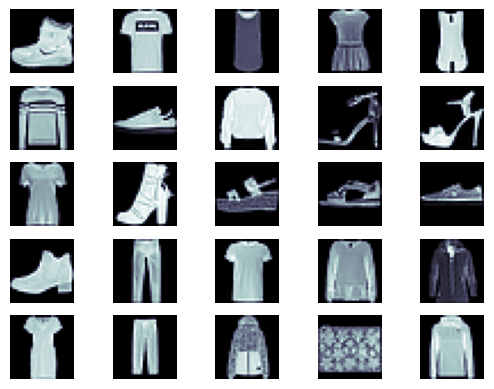

In [8]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

## Now get a validation set

We further split up the training data into training and validation sets.
Recall that the validation set is different from the test set. The validation set can be used to select hyperparameters, so is strictly part of the model selection process.

In [9]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


## 1. Build the network architecture

Our first DNN will be a simple multi-layer perceptron with only one hidden layer, as shown in the following figure:


![dense.jpeg](https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/dnn.png?raw=1)


In general, a network of this kind should include an input layer, some hidden layers and an output layer. In this example, all the layers will be `Dense` layers.


### The input layer

We first need to determine the dimensionality of the input layer. In this case, we flatten (using a `Flatten` layer) the images and feed them to the network. As the images are 28 $\times$ 28 in pixels, the input size will be 784.


### The hidden layers

We use one hidden layer in this case and use `ReLU` as its activation function:

> $R(x)=\max(0,x)$

**NOTE**: Different activation functions are used for different tasks. Remember that `ReLU` generally performs well for training a network, but it can *only* be used in the hidden layers.


### The output layer

We usually encode categorical data as a "one-hot" vector. In this case, we have a vector of length 10 on the output side, where each element corresponds to a class of apparel. Ideally, we hope the values to be either 1 or 0, with 1 for the correct class and 0 for the others, so we use `sigmoid` as the activation function for the output layer:

> $S(x) = \dfrac{1}{1 + e^{-x}}$

**Note**: PyTorch combines activation functions to be applied on the output with the functions which calculate the loss, also known as error or cost, of a neural network. This is done for numerical stability. So we do not explicitly declare the `Sigmoid` functions, rather this is done by the loss function later.

## Set up the network

In `pytorch` we build networks as a class. The example below is the minimal format for setting up a network in `pytorch`

* Declare the class - it should be a subclass of the `nn.Module` class from `pytorch`
* Define what inputs it takes upon declaration - in this case `input_dim` and `output_dim`
* `super` makes sure it inherits attributes from `nn.Module`
* We then define the different types of layers that we will use in this case three different linear layers
* Then we define a method `forward` which is what gets called when data is passed through the network, this basically moves the data `x` through the layers

```python
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)  # Here we set the first hidden layer to have 250 neurons
        self.hidden_fc = nn.Linear(250, 100)       # The second hidden layer has 100 neurons
        self.output_fc = nn.Linear(100, output_dim)# The output layer size is declared when setting up the network

    def forward(self, x):          

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))     # First pass through the Linear neuron, then pass through a ReLU
        h_2 = F.relu(self.hidden_fc(h_1))  # First pass through the Linear neuron, then pass through a ReLU
        y_pred = self.output_fc(h_2)       # First pass through the Linear neuron, don't declare activation for the output layer, that is implicit in the loss function

        return y_pred
```

**Note** we did not set an activation function for the final layer - actually `PyTorch` does this automatically, based on the loss function that you choose.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)  # Here we set the first hidden layer to have 250 neurons
        self.hidden_fc = nn.Linear(250, 100)       # The second hidden layer has 100 neurons
        self.output_fc = nn.Linear(100, output_dim)# The output layer size is declared when setting up the network

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))     # First pass through the Linear neuron, then pass through a ReLU
        h_2 = F.relu(self.hidden_fc(h_1))  # First pass through the Linear neuron, then pass through a ReLU
        y_pred = self.output_fc(h_2)       # First pass through the Linear neuron, don't declare activation for the output layer, that is implicit in the loss function

        return y_pred

Now use this class to build a network

In [14]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

## Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter

We use the *Adam* algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*.

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1.

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [15]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

## Look for GPUs

In toorch the code automatically defaults to run on cpu. You can check for avialible gpus, then move all of the code across to GPU if you like.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Set up the batches

We will do mini-batch gradient descent with Adam. So we can set up the batch sizes

In [18]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Define a training loop

This will:

    put our model into train mode
    iterate over our dataloader, returning batches of (image, label)
    place the batch on to our GPU, if we have one
    clear the gradients calculated from the last batch
    pass our batch of images, x, through to model to get predictions, y_pred
    calculate the loss between our predictions and the actual labels
    calculate the accuracy between our predictions and the actual labels
    calculate the gradients of each parameter
    update the parameters by taking an optimizer step
    update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

```python
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)                   # Move the data to the device where you want to compute
        y = y.to(device)

        optimizer.zero_grad()              # Initialise the optimiser

        y_pred = model(x)                  # Obtain initial predictions

        loss = criterion(y_pred, y)        # Calculate the loss

        acc = calculate_accuracy(y_pred, y)

        loss.backward()                    # Backprop the loss to update the weights

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
```

In [21]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)                   # Move the data to the device where you want to compute
        y = y.to(device)

        optimizer.zero_grad()              # Initialise the optimiser

        y_pred = model(x)                  # Obtain initial predictions

        loss = criterion(y_pred, y)        # Calculate the loss

        acc = calculate_accuracy(y_pred, y)

        loss.backward()                    # Backprop the loss to update the weights

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Setr up an evaluation loop

This is very similar to the training loop, except that we do not pass the gradients back to updated the weights.

In [22]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Run the training

Here we will train for 10 epochs.
At the end of each epoch we check the validation loss, if it is better than the previous best, then we save the model

In [24]:
EPOCHS = 10

best_valid_loss = float('inf')
history = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_acc': valid_acc, 'train_acc': train_acc})

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.469 | Train Acc: 82.92%
	 Val. Loss: 0.412 |  Val. Acc: 85.17%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.348 | Train Acc: 87.22%
	 Val. Loss: 0.366 |  Val. Acc: 86.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.312 | Train Acc: 88.49%
	 Val. Loss: 0.357 |  Val. Acc: 86.54%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.288 | Train Acc: 89.20%
	 Val. Loss: 0.326 |  Val. Acc: 88.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.267 | Train Acc: 90.01%
	 Val. Loss: 0.316 |  Val. Acc: 88.96%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.249 | Train Acc: 90.68%
	 Val. Loss: 0.313 |  Val. Acc: 88.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.237 | Train Acc: 90.95%
	 Val. Loss: 0.322 |  Val. Acc: 88.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.225 | Train Acc: 91.53%
	 Val. Loss: 0.316 |  Val. Acc: 89.29%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.209 | Train Acc: 92.06%
	 Val. Loss: 0.327 |  Val. Acc: 88.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 0.203 | Train Acc: 92.34%
	 Val. Loss: 0.347 |  Val. Acc: 88.30%


## Plot the model training

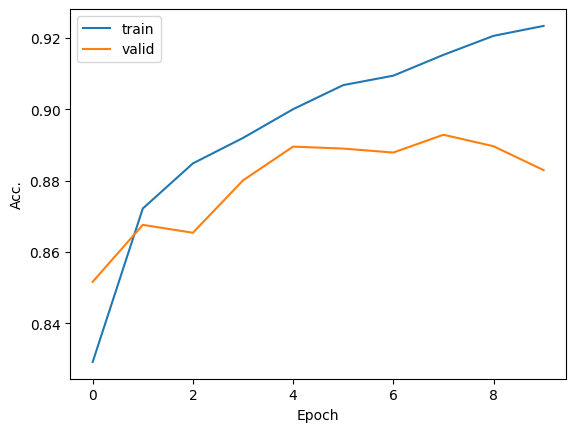

In [25]:
epochs = [x["epoch"] for x in history]
train_loss = [x["train_acc"] for x in history]
valid_loss = [x["valid_acc"] for x in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="train")
ax.plot(epochs, valid_loss, label="valid")
ax.set(xlabel="Epoch", ylabel="Acc.")
plt.legend()

## Try on the test set

Now we can try it on the test set

In [26]:
model.load_state_dict(torch.load('mlp-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

<ipython-input-26-21697a5bd7d2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp-model.pt'))


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.334 | Test Acc: 88.32%


# Exercises

1. Add rotations to the test data and see how well the model performs. Compare this to the CNNs with rotations added.
You add rotations in the transforms, so declare a new transform and a new test data set:

```python

roated_test_transforms = transforms.Compose([
                           transforms.RandomRotation(25, fill=(0,)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

rotated_test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=roated_test_transforms)

rotated_test_iterator = data.DataLoader(rotated_test_data,
                                batch_size=BATCH_SIZE)

```

2. Add some regularisation using dropout:
Dropout is defined like this:
```
 # Define proportion or neurons to dropout
    self.dropout = nn.Dropout(0.25)
```
And then you add it between layers, before passing through the activation function. Add the dropout between the two hidden layers.
     


3. Try some simple hyperparameter tuning, change the number of neurons in the hidden layer to 64 and 256. Does it make a difference?


In [27]:
roated_test_transforms = transforms.Compose([
                           transforms.RandomRotation(25, fill=(0,)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                      ])

rotated_test_data = datasets.FashionMNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=roated_test_transforms)

rotated_test_iterator = data.DataLoader(rotated_test_data,
                                batch_size=BATCH_SIZE)

In [28]:
# Define proportion or neurons to dropout
 self.dropout = nn.Dropout(0.25)

IndentationError: unexpected indent (<ipython-input-28-3ccbd285a6bc>, line 2)